# PlantEx
## Distortion analysis
---

Steps:
0. Import required Python modules
1. Define helper functions 
2. Specify input parameters
3. Compute local distortion field (from pre- to PlantEx image)
4. Calculates the magnitude the distortion field (histogram)

Each code block can be executed by "SHIFT+Enter"

In [1]:
import os
import cv2
import pandas
import tifffile
import matplotlib
from numpy import ma
import numpy; np=numpy
from skimage import color, filters
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt; plt.ion()
from skimage.exposure import rescale_intensity
from scipy.stats import pearsonr

## Helper functions
___

In [2]:
# setup colormaps for later display
cmap = numpy.zeros((256,4))
cmap[:,3] = 1
cmap[:,0] = numpy.linspace(0, 1,256)
cmap[:,2] = numpy.linspace(0, 1,256)
magenta = matplotlib.colors.ListedColormap(cmap)

cmap = numpy.zeros((256,4))
cmap[:,3] = 1
cmap[:,1] = numpy.linspace(0, 1,256)
green = matplotlib.colors.ListedColormap(cmap)

# calculation of deformation field
def calc_flow(img1, img2):
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 
                                        levels=3, 
                                        winsize=winsize, 
                                        iterations=3, 
                                        poly_n=5, 
                                        poly_sigma=poly_sigma, 
                                        flags=0)
    u = flow[...,0]
    v = flow[...,1]
    
    return u, v

# display subsampled deformation field with arrows
def show_flow_field(u, v, ax=None, subsample=32, color='r', scale=1/2):
    if ax is None:
        ax = plt.gca()
    x_, y_ = numpy.meshgrid(range(0, u.shape[1]), range(0, u.shape[0]))
    ax.quiver( x_[subsample//2::subsample, subsample//2::subsample], 
               y_[subsample//2::subsample, subsample//2::subsample], 
               u [subsample//2::subsample, subsample//2::subsample], 
               v [subsample//2::subsample, subsample//2::subsample],  
              angles='xy', 
              scale_units='xy', 
              scale=scale, 
              pivot='mid', 
              headwidth=2,
              headlength=3,
              color=color,
              width=0.002)

## Inputs
___

In [3]:
# Input images (saved as tif)
image_pair_in_filename = "data/arabidopsis_tubulin.tif"

# Input user defined mask (with Fiji polygon selection tool)
image_mask_fn = "data/arabidopsis_tubulin_mask.tif"


In [4]:
### Basic parameters for optimal results with the suplied images
pixel_size  = 0.0902363 # in microns
subsample   = 16
winsize     = 41
poly_sigma  = 3

# Smoothing of PlantEx image
post_image_sigma = 7

## Compute local distortion field
___

In [5]:
# Read images and mask
img_pair_in = tifffile.imread(image_pair_in_filename)
img_mask    = tifffile.imread(image_mask_fn)

# First image is pre-exansion
img_pre   = img_pair_in[0]

# Second PlantEx
img_post  = img_pair_in[1]

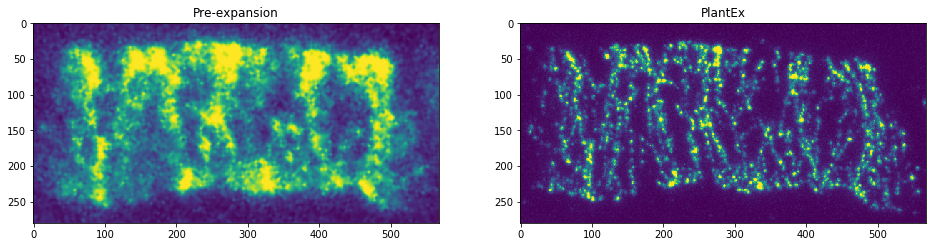

In [6]:
f, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].imshow(img_pre)
ax[0].set_title("Pre-expansion")

ax[1].imshow(img_post)
ax[1].set_title("PlantEx");

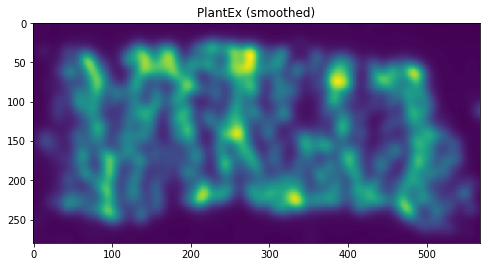

In [7]:
# Convolution with Gaussian of PlantEx image 
# to mimic lower resolution for overlay with pre-expansion image
img_post = filters.gaussian(img_post, post_image_sigma, preserve_range=True)

f, ax = plt.subplots( figsize=(8,5))
ax.imshow(img_post)
ax.set_title("PlantEx (smoothed)");

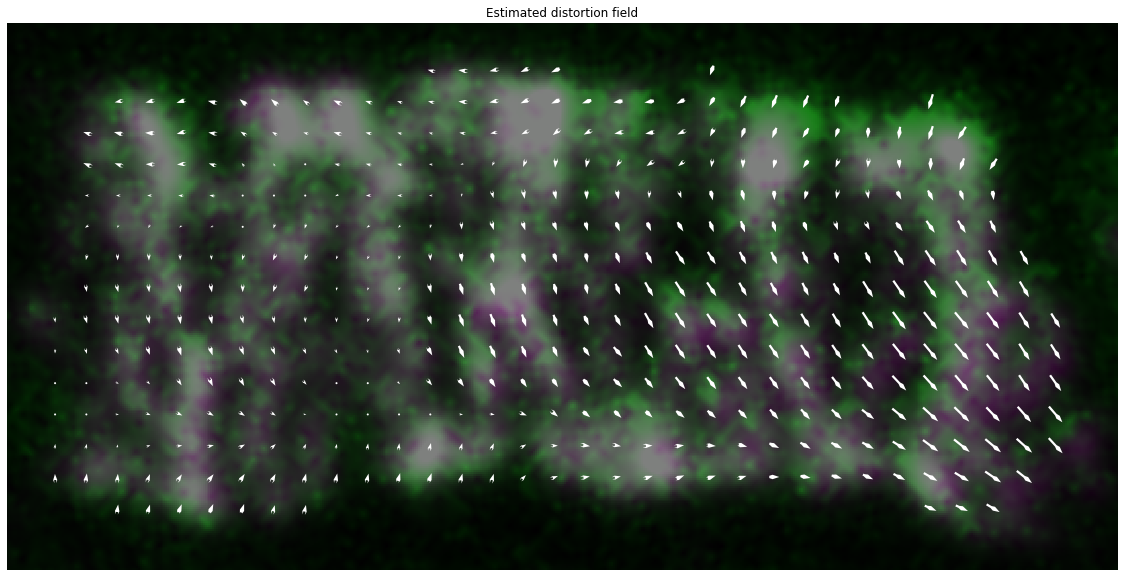

In [8]:
# Normalize intensities
img_post = rescale_intensity(img_post, (img_post.min(), numpy.percentile(img_post, 99)), 'uint8')
img_pre  = rescale_intensity(img_pre,  (img_pre.min(),  numpy.percentile(img_pre,  99)), 'uint8')

# Calculate distortions
u, v = calc_flow(img_pre, img_post)

# Quiver plot
f = plt.figure(figsize=(16, 8))

ax = plt.Axes(f, [0,0,1,0.95],
                 yticks=[],
                 xticks=[],
                 frame_on=False)
f.add_axes(ax)
ax = plt.gca()

tmp = numpy.zeros(img_post.shape + (3,), dtype=numpy.uint8)
tmp[..., 0] = img_pre
tmp[..., 1] = img_post

ax.imshow(img_pre,  cmap=green, alpha=1)
ax.imshow(img_post, cmap=magenta, alpha=0.5)

ax.set_axis_off()

U = ma.masked_array(u, mask=img_post==img_post.min())
V = ma.masked_array(v, mask=img_post==img_post.min())

U = ma.masked_array(u, mask=img_mask)
V = ma.masked_array(v, mask=img_mask)

show_flow_field(U, V, ax, color='w', scale=1., subsample=subsample)
plt.title("Estimated distortion field");

## Calculate the magnitude of the distortion field
___

In [9]:
# Compute distortions magnitudes
mag = numpy.sqrt(u**2 + v**2)

# Scale to physical unit (microns)
mag_um = mag * pixel_size

# Apply mask
mag_um = mag_um[img_mask == 0]

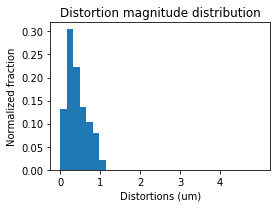

In [10]:
# plot histogram of magnitudes
# Scale refers to physical size after expansion 
# for distortions refering to the original tissue size, 
# these should be divided by the expansion factor

f = plt.figure(figsize=(4, 3))
bins = numpy.linspace(0,5,32)
hist_data = numpy.histogram(mag_um.ravel(), bins=bins)[0].astype(numpy.float32)

plt.bar(bins[:-1]+bins[1]/2, hist_data / hist_data.sum(), width=bins[1])
plt.xlabel("Distortions (um)")
plt.ylabel("Normalized fraction")
plt.xticks(range(5))
plt.title("Distortion magnitude distribution")
plt.tight_layout()